### Best Management Practice (BMP) Application Programming Interface (API)
###### Academy of Natural Sciences of Drexel University,  Drexel University College of Computing and Informatics

The Drexel University College of Computing and Informatics (CCI) and the Academy of Natural Sciences (ANS) of Drexel University have developed Application Programming Interfaces (APIs) which incorporate novel algorithms to apply efficient solutions to complex environmental queries. The APIs are built in Python using a GeoDjango Web framework, Nginx, Docker, PostgreSQL, and Swagger.

The Best Management Practice (BMP) API returnes BMP specific nutrient and sediment reduction estimates for a user-supplied area of interest. The API supports BMPs within the Delaware and Chesapeake Bay basins. In the Delaware, the API uses the Generalized Watershed Loading Funtion Enhanced (GWLF-E) model outputs at the HUC12 scale. In the Chesapeake, the API relies on the Chesapeake Bay Model scenarios within the Chesapeake Assessment Scenario Tool (CAST), also at the HUC12 scale. The API calculates the watershed boundary and land cover distribution for the BMP area of interest, then re-allocates the loads using BMP specific modeling approaches and efficiencies. BMP efficiencies used vary spatially depending on the watershed. This API is being extended to incorporate local factors that affect pollutant transport and BMP efficiency, such as ecoregion or soils.

In [1]:
from ipyleaflet import Map, basemaps, Polygon, DrawControl, WidgetControl, GeoJSON, MeasureControl, basemap_to_tiles, SplitMapControl
import ipywidgets as widgets
from ipywidgets import IntSlider, ColorPicker, jslink, Dropdown, interact, FloatSlider
import requests
import geojson
import json
import shapely
from shapely.geometry import mapping, MultiPolygon, Polygon, LineString, Point
import matplotlib.pyplot as plt
import collections
from math import sqrt
import numpy as np
from shapely.ops import unary_union

In [2]:
# Copy in the lookup table from the BMP API
bmp_lookups = {"": [],
                      "Agricultural Animal": [
                      #"",
                      "Animal Waste Management Systems",
                      "Waste Storage Facility",
                      "Waste Storage Pond",
                      "Waste Storage Structure"
                      ],
                      "Stream Restoration": [
                      #"",
                      "Watering Facility",
                      "Fence",
                      "Non-Urban Stream Restoration",
                      "Stream Channel Stabilization",
                      "Streambank and Shoreline Protection",
                      "Urban Stream Restoration"
                      ],
                    "Land Use Change": [
                      #"",
                      "Tree and Shrub Establishment",
                      "Tree Planting",
                      "Barnyard Runoff Controls",
                      "Conservation Easement",
                      "Heavy Use Area Protection",
                      "Roof Runoff Management",
                      "Roof Runoff Structure",
                      "Roofs and Covers"
                      ],
                    "Agricultural Land": [
                      #"",
                      "Conservation Tillage",
                      "Reduced Tillage",
                      "High Residue Tillage Management",
                      "Soil Conservation and Water Quality Plans",
                      "Comprehensive Nutrient Management Plan",
                      "Nutrient Management",
                      "Conservation Cover",
                      "Cover Crop",
                      "Grazing Land Protection",
                      "Prescribed Grazing"
                      ],
                    "Urban Stormwater Management": [
                      #"",
                      "Constructed Wetland",
                      "Dry Extended Detention Ponds",
                      "Wet Pond",
                      "Wet Ponds & Wetlands",
                      "Bioretention",
                      "Bioretention/raingardens - A/B soils  no underdrain",
                      "Bioretention/raingardens - A/B soils no underdrain",
                      "Bioretention/raingardens - C/D soils  underdrain",
                      "Bioretention/raingardens - C/D soils  no underdrain",
                      "Bioswale",
                      "Dry Well/Seepage Pit",
                      "Impervious Surface Reduction",
                      "Infiltration Practices w/o Sand  Veg. - A/B soils  no underdrain",
                      "Permeable Pavement w/o Sand  Veg. - A/B soils  no underdrain",
                      "Stormwater Performance Standard-Runoff Reduction",
                      "Urban Infiltration Practices",
                      "Stormwater Performance Standard-Stormwater Treatment"
                      ],
                    "Polygon Drainage": [
                      #"",
                      "Forest Buffer",
                      "Forest Buffer - Narrow",
                      "Riparian Herbaceous Cover",
                      "Grass Buffers",
                      "Grass Buffer - Narrow",
                      "Grassed Waterway",
                      "Wetland Creation - Floodplain",
                      "Wetland Restoration",
                      "Wetland Restoration - Floodplain"
                      ],
                    "Exclusion Buffer": [
                      #"",
                      "Forest Buffer-Streamside with Exclusion Fencing",
                      "Forest Buffer-Narrow with Exclusion Fencing",
                      "Grass Buffer-Streamside with Exclusion Fencing",
                      "Grass Buffer-Narrow with Exclusion Fencing",
                      ]
                  }

messages_arch = {"": '',
                 "Agricultural Animal": 'Draw the point where the farm is located and enter the number of animals treated by the BMP.',
                 "Stream Restoration": 'Draw the line representing the BMP and (optionally) enter the length of stream treated.',
                 "Land Use Change": 'Draw the point or polygon representing the BMP and enter the acres treated (optional if a polygon is drawn).',
                 "Agricultural Land": 'Draw the point or polygon representing the BMP and enter the acres treated (optional if a polygon is drawn).',
                 "Urban Stormwater Management": 'Draw the polygon for the BMP or the drainage area to the BMP and provide the drainage area (acres, optional), percent impervious (%, optional) and runoff capture (inches, optional).',
                 "Polygon Drainage": 'Draw the polygon footprint for your BMP.',
                 "Exclusion Buffer": 'Draw the polygon footprint for your BMP and enter the length of fencing.'
                }

# Sort this dictionary for better viewing
bmp_lookups_sort = {}
for arch in sorted(bmp_lookups):
    bmp_lookups_sort[arch] = bmp_lookups[arch]
    temp = []
    for bmp in sorted(bmp_lookups[arch]):
        temp.append(bmp)
        #print("%s: %s" % (key, bmp_lookups[key]))
    bmp_lookups_sort[arch] = temp

bmp_lookups = dict(bmp_lookups_sort)
del(bmp_lookups_sort)

# bmp_lookups.keys()


In [3]:
# Set up all of the different fields to populate

acres_treated = 0.0
percent_impervious = 0.0
runoff_capture = 0.5
stream_feet_treated = 0.0
number_of_units = 1.0
animal_treated = {
    "chickens_broilers": 0.0,
    "chickens_layers": 0.0,
    "cows_beef": 0.0,
    "cows_dairy": 0.0,
    "horses": 0.0,
    "pigs_hogs_swine": 0.0,
    "sheep": 0.0,
    "turkeys": 0.0
    }

acres_treated_text = widgets.BoundedFloatText(
    value=acres_treated,
    min=0.00,
    max=10000.0,
    placeholder='Enter Acres Treated:',
    description='Acres',
    disabled=False
)

drainage_acres_treated_text = widgets.BoundedFloatText(
    value=acres_treated,
    min=0.00,
    max=10000.0,
    placeholder='Enter Drainage Area Treated (Ac.):',
    description='DA (Ac.)',
    disabled=False
)

percent_impervious_text = widgets.BoundedFloatText(
    value=percent_impervious,
    placeholder='Enter Percent Impervious:',
    min=0.00,
    max=100.0,
    description='% Impervious',
    disabled=False
)

runoff_capture_text = widgets.BoundedFloatText(
    value=runoff_capture,
    min=0.05,
    max=2.5,
    step=0.1,
    placeholder='Enter Runoff Capture (inches):',
    description='Capture (in.)',
    disabled=False
)

runoff_capture_slider = FloatSlider(min=0.05, max=2.5, step=0.05, value=1)

stream_feet_treated_text = widgets.BoundedFloatText(
    value=stream_feet_treated,
    min=0.00,
    max=10000.0,
    placeholder='Enter Stream Feet Treated:',
    description='',
    disabled=False
)

number_of_units_text = widgets.BoundedFloatText(
    value=number_of_units,
    min=0.00,
    max=10.0,
    placeholder='Enter Number of Units:',
    description='',
    disabled=False
)

# FOR ANIMALS

chickens_broilers_text = widgets.BoundedFloatText(
    value=0,
    min=0.00,
    max=1000.0,
    description='Broilers',
    disabled=False
)

chickens_layers_text = widgets.BoundedFloatText(
    value = None,
    min=0.00,
    max=1000.0,
    description='Layers',
    disabled=False
)

cows_beef_text = widgets.BoundedFloatText(
    value=0,
    min=0.00,
    max=1000.0,
    description='Beef Cows',
    disabled=False
)

cows_dairy_text = widgets.BoundedFloatText(
    value=0,
    min=0.00,
    max=1000.0,
    description='Dairy Cows',
    disabled=False
)

horses_text = widgets.BoundedFloatText(
    value=0,
    min=0.00,
    max=1000.0,
    description='Horses',
    disabled=False
)

pigs_hogs_swine_text = widgets.BoundedFloatText(
    value=0,
    min=0.00,
    max=1000.0,
    description='Hogs/Swine',
    disabled=False
)

sheep_text = widgets.BoundedFloatText(
    value=0,
    min=0.00,
    max=1000.0,
    description='Sheep',
    disabled=False
)

turkeys_text = widgets.BoundedFloatText(
    value=0,
    min=0.00,
    max=1000.0,
    description='Turkeys',
    disabled=False
)

In [4]:
# Put in a DropDown Widget to Select a BMP and enter the necessary information
bmps_selected = []
arches_selected = []


def select_bmp(Archetype):
    arches_selected.append(Archetype)
    bmpW.options = bmp_lookups[Archetype]

def print_bmp(BMP):
    if BMP == None:
        pass
    else:
        print('Selected BMP: {}\n'.format(BMP))
        print(messages_arch[str(scW.value)])
        bmps_selected.append(BMP)
        if str(scW.value) == 'Agricultural Animal':
            display(chickens_broilers_text)
            display(chickens_layers_text)
            display(cows_beef_text)
            display(cows_dairy_text)
            display(horses_text)
            display(pigs_hogs_swine_text)
            display(sheep_text)
            display(turkeys_text)
        elif str(scW.value) == 'Agricultural Land':
            display(acres_treated_text)
        elif str(scW.value) == 'Exclusion Buffer':
            display(stream_feet_treated_text)
        elif str(scW.value) == 'Land Use Change':
            display(acres_treated_text)
        elif str(scW.value) == 'Polygon Drainage':
            pass
        elif str(scW.value) == 'Stream Restoration':
            display(stream_feet_treated_text)
        elif str(scW.value) == 'Urban Stormwater Management':
            display(drainage_acres_treated_text)
            display(percent_impervious_text)
            display(runoff_capture_text)
            
        
scW = widgets.Dropdown(options=bmp_lookups.keys())
init = scW.value
bmpW = widgets.Dropdown(options=bmp_lookups[init])
disp_bmp = widgets.interactive(print_bmp, BMP=bmpW)
disp_arch = widgets.interactive(select_bmp, Archetype=scW)
display(disp_arch)
display(disp_bmp)


# Create the map
# Map centred on Wissahickon Park
displaymap1 = Map(center = (40.050, -75.215), zoom = 12, min_zoom = 1, max_zoom = 20,  scroll_wheel_zoom = True,
                 basemap = basemaps.Esri.WorldStreetMap)

# Enable user to draw polygons and lines
draw_control = DrawControl()
draw_control.polyline =  {
    "shapeOptions": {
        "color": "#6bc2e5",
        "weight": 4,
        "opacity": 1.0
    }
}
draw_control.polygon = {
    "shapeOptions": {
        "fillColor": "#6be5c3",
        "color": "#6be5c3",
        "fillOpacity": 0.3
    },
    "drawError": {
        "color": "#dd253b",
        "message": "Oups!"
    },
    "allowIntersection": True,
}

# Save the drawn geometry to a geojson
feature_collection = {
    'type': 'FeatureCollection',
    'features': []
}

def handle_draw(self, action, geo_json):
    # Save the GeoJSON when it's drawn on the map  
    feature_collection['features'].append(geo_json)

# Add in a zoom slider bar for fun
zoom_slider1 = IntSlider(description='Zoom level:', min=0, max=20, value=12)
jslink((zoom_slider1, 'value'), (displaymap1, 'zoom'))
widget_control1 = WidgetControl(widget=zoom_slider1, position='topright')

# Add in ability to do measurements
measure = MeasureControl(
    position='bottomleft',
    active_color = 'red',
    primary_length_unit = 'feet'
)

displaymap1.add_control(measure)

measure.completed_color = 'red'

measure.add_length_unit('miles', 0.000621371, 1)
measure.secondary_length_unit = 'miles'

measure.add_area_unit('sqkm', 0.0000001, 1)
measure.secondary_area_unit = 'sqkm'

# Add everything into the map
draw_control.on_draw(handle_draw)
displaymap1.add_control(draw_control)

left_layer = basemap_to_tiles(basemaps.Esri.WorldImagery)
right_layer = basemap_to_tiles(basemaps.Esri.WorldStreetMap)

#split_control = SplitMapControl(left_layer=left_layer, right_layer=right_layer)
#displaymap1.add_control(split_control)

# Show the map
displaymap1

interactive(children=(Dropdown(description='Archetype', options=('', 'Agricultural Animal', 'Agricultural Land…

interactive(children=(Dropdown(description='BMP', options=(), value=None), Output()), _dom_classes=('widget-in…

Map(center=[40.05, -75.215], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [67]:
# Show the BMP
model = 'gwlfe'
bmp = bmps_selected[len(bmps_selected)-1]
archetype = arches_selected[len(arches_selected)-1]
print('{}: {}'.format(archetype, bmp))

# Show the last drawn shape
last_geom_idx = len(feature_collection['features']) - 1
last_geom = feature_collection['features'][last_geom_idx]['geometry']
print(last_geom)

# Update the paramters with the user supplied input
acres_treated = drainage_acres_treated_text.value
percent_impervious = percent_impervious_text.value
runoff_capture = runoff_capture_text.value
stream_feet_treated = stream_feet_treated_text.value
number_of_units = number_of_units_text.value
animal_treated = {
    "chickens_broilers": chickens_broilers_text.value,
    "chickens_layers": chickens_layers_text.value,
    "cows_beef": cows_beef_text.value,
    "cows_dairy": cows_dairy_text.value,
    "horses": horses_text.value,
    "pigs_hogs_swine": pigs_hogs_swine_text.value,
    "sheep": sheep_text.value,
    "turkeys": turkeys_text.value
    }


Polygon Drainage: Forest Buffer
{'type': 'Polygon', 'coordinates': [[[-76.039178, 40.049125], [-76.038749, 40.049737], [-76.03795, 40.050129], [-76.037019, 40.050321], [-76.036745, 40.049645], [-76.037711, 40.04939], [-76.038236, 40.04918], [-76.038617, 40.048915], [-76.039178, 40.049125]]]}


#### Call BMP API

In [68]:
# Call the Watersheds API with the drawn shape
_x = dict(eval(str(last_geom)))
_payload = {"bmp_geometry": _x,
            "bmp_type": bmp,
            "bmp_group": archetype,
            "animal_treated": animal_treated,
            "acres_treated": acres_treated,
            "stream_feet_treated": stream_feet_treated,
            "percent_impervious": percent_impervious,
            "runoff_capture": runoff_capture,
            "number_of_units": number_of_units,
            "model": model
           }
_payload = json.dumps(_payload)
_url = 'https://watersheds.cci.drexel.edu/api/bmp/'
_headers = {'Content-Type': 'application/json'}
_r_bmp = requests.post(_url, data = _payload , headers= _headers, allow_redirects=True, verify=True)

print('{')
for k, v in eval(_payload).items():
    print('\t{}: {}'.format(k, v))
print('}')
# print(_r_bmp.text)

{
	bmp_geometry: {'type': 'Polygon', 'coordinates': [[[-76.039178, 40.049125], [-76.038749, 40.049737], [-76.03795, 40.050129], [-76.037019, 40.050321], [-76.036745, 40.049645], [-76.037711, 40.04939], [-76.038236, 40.04918], [-76.038617, 40.048915], [-76.039178, 40.049125]]]}
	bmp_type: Forest Buffer
	bmp_group: Polygon Drainage
	animal_treated: {'chickens_broilers': 0.0, 'chickens_layers': 0.0, 'cows_beef': 0.0, 'cows_dairy': 0.0, 'horses': 0.0, 'pigs_hogs_swine': 0.0, 'sheep': 0.0, 'turkeys': 0.0}
	acres_treated: 0.0
	stream_feet_treated: 0.0
	percent_impervious: 0.0
	runoff_capture: 0.5
	number_of_units: 1.0
	model: gwlfe
}


In [69]:
parsed = json.loads(_r_bmp.text)
print(json.dumps(parsed, indent=2, sort_keys=False))

{
  "bmp_geometry": "{\"type\":\"MultiPolygon\",\"coordinates\":[[[[-76.0368544447331,40.0499150186682],[-76.0367450000002,40.0496449999999],[-76.0377110000002,40.0493899999999],[-76.0382360000002,40.0491799999999],[-76.0386170000002,40.0489149999999],[-76.0386189062021,40.0489157135583],[-76.0382420933031,40.0493727703547],[-76.0379204528951,40.0496694333999],[-76.0371648051215,40.0498906534708],[-76.0368544447331,40.0499150186682]]],[[[-76.0391780000002,40.0491249999999],[-76.0387490000002,40.0497369999999],[-76.0379500000002,40.0501289999999],[-76.0370190000002,40.0503209999999],[-76.0369732155923,40.0502080438547],[-76.0375630665289,40.0501428194247],[-76.0375673169558,40.0501422258015],[-76.0375759606666,40.0501407638385],[-76.037584248733,40.0501388597117],[-76.0375925060587,40.0501364395529],[-76.0376003662828,40.0501336069682],[-76.0376080518926,40.0501302829327],[-76.0376117679184,40.0501285328561],[-76.0384905936782,40.0496792702778],[-76.0384941521846,40.0496772996372],[-76.

In [70]:
# Cache what we want to use later in the visualization

# Save the watershed as a geojson and a shapely geometry object
return_dict = eval(str(json.loads(_r_bmp.text)))

watershed_shapely = shapely.geometry.shape(return_dict['watershed_geometry'])
if watershed_shapely.type == 'Polygon':
    watershed_shapely = MultiPolygon([watershed_shapely])
watershed_geojson = geojson.loads(geojson.dumps(mapping(watershed_shapely)))

#watershed_shapely = unary_union(watershed_shapely)
#watershed_geojson = geojson.loads(geojson.dumps(mapping(watershed_shapely)))

# Cache land cover and final recutions
lulcs = return_dict['land_cover_acres']
lulcs_bmp = return_dict['land_cover_acres']
reductions = return_dict['reduction_lbyr']
p_impervious = return_dict['percent_impervious']
lu_total = 0
lu_total_bmp = 0
for lulc, acre in lulcs_bmp.items():
    lu_total_bmp += acre
#print(lu_total_bmp)
#print('Input area ammended land cover acres: {}\n'.format(lulcs_bmp))

# In case we get a zero area, double check by re-sending the watershed boundary
# Reset area for providing warnings with urban stormwater management BMPs
try:
    if lu_total_bmp >= 0:
        lulcs = {}
        lu_total = 0
        n = 1
        # Call the Fast Zonal API with the Watershed Boundary
        for geom in watershed_shapely:
            print(n, end='')
            m = MultiPolygon([geom])
            new_watershed_geojson = geojson.loads(geojson.dumps(mapping(m)))
            _x = json.dumps(new_watershed_geojson)
            _url = 'https://watersheds.cci.drexel.edu/api/fzs/'
            _headers = {}
            _r = requests.post(_url, data = _x , headers= _headers, allow_redirects=True, verify=True)
            lulcs_loop = eval(_r.text)
            for lulc, sqm in lulcs_loop.items():
                if lulc in lulcs.keys():
                    _v = sqm / 4046.86
                    lulcs[lulc] += _v
                else:
                    lulcs[lulc] = sqm / 4046.86
            n += 1
        for lulc, acre in lulcs.items():
            lu_total += acre
        
    #print('\nRaw land cover acres: {}'.format(lulcs))
    #print(lu_total)
except Exception as e:
    print(e)

12

#### Call OSI API

In [71]:
return_dict['watershed_geometry']
temp = dict({ "type": "MultiPolygon", "coordinates": [ [ [ [ -74.765000308583041, 41.165270858418161 ], [ -74.764334823710072, 41.164560835257987 ], [ -74.764339, 41.16456 ], [ -74.764464, 41.164514 ], [ -74.764618, 41.164457 ], [ -74.764686, 41.164428 ], [ -74.764743, 41.16441 ], [ -74.764858, 41.164383 ], [ -74.764933, 41.164358 ], [ -74.765013, 41.164316 ], [ -74.765302, 41.164165 ], [ -74.76565, 41.163954 ], [ -74.765693, 41.163927 ], [ -74.765866, 41.163825 ], [ -74.766076, 41.163691 ], [ -74.766108, 41.163669 ], [ -74.766473, 41.163412 ], [ -74.766583, 41.163335 ], [ -74.767029, 41.163021 ], [ -74.7671, 41.162971 ], [ -74.767133, 41.162943 ], [ -74.767192, 41.162883 ], [ -74.767241, 41.162856 ], [ -74.767278, 41.162849 ], [ -74.767301, 41.162849 ], [ -74.767323, 41.162858 ], [ -74.767381, 41.162893 ], [ -74.767395, 41.162901 ], [ -74.76741, 41.162911 ], [ -74.767415, 41.162927 ], [ -74.767412, 41.162948 ], [ -74.767339, 41.163179 ], [ -74.767338, 41.163205 ], [ -74.767345, 41.163229 ], [ -74.767373, 41.163261 ], [ -74.767455, 41.163338 ], [ -74.767496, 41.163388 ], [ -74.767518, 41.163417 ], [ -74.767538, 41.163465 ], [ -74.767546, 41.163498 ], [ -74.767549, 41.163541 ], [ -74.76757, 41.163671 ], [ -74.767583, 41.163721 ], [ -74.767609, 41.163759 ], [ -74.767579, 41.163852 ], [ -74.767593, 41.163891 ], [ -74.767677, 41.163957 ], [ -74.767698, 41.164006 ], [ -74.767705, 41.164108 ], [ -74.767777, 41.16415 ], [ -74.767788, 41.164157 ], [ -74.767755, 41.164171 ], [ -74.767567, 41.164222 ], [ -74.767537, 41.164241 ], [ -74.767503, 41.164266 ], [ -74.767467, 41.164302 ], [ -74.767413, 41.164333 ], [ -74.767359, 41.164354 ], [ -74.766062, 41.164732 ], [ -74.765975, 41.164768 ], [ -74.765896, 41.164814 ], [ -74.765824, 41.164859 ], [ -74.765752, 41.164896 ], [ -74.765674, 41.164936 ], [ -74.765000308583041, 41.165270858418161 ] ] ], [ [ [ -74.764258, 41.163513 ], [ -74.764262, 41.16351 ], [ -74.764743, 41.163237 ], [ -74.765621, 41.162742 ], [ -74.766306, 41.162364 ], [ -74.767051, 41.161958 ], [ -74.767202, 41.161883 ], [ -74.767545, 41.162154 ], [ -74.766789, 41.162602 ], [ -74.765475, 41.163396 ], [ -74.764543, 41.16378 ], [ -74.764258, 41.163513 ] ] ], [ [ [ -74.769347, 41.162123 ], [ -74.769394, 41.162069 ], [ -74.769485, 41.161901 ], [ -74.769515, 41.161857 ], [ -74.769507, 41.161819 ], [ -74.769387, 41.161784 ], [ -74.768913, 41.161777 ], [ -74.768695, 41.161803 ], [ -74.768271, 41.161911 ], [ -74.768043, 41.161995 ], [ -74.767962, 41.162014 ], [ -74.767914, 41.162007 ], [ -74.76789, 41.161991 ], [ -74.767881, 41.161958 ], [ -74.767858, 41.161876 ], [ -74.768135, 41.161637 ], [ -74.768412, 41.161474 ], [ -74.768307, 41.161271 ], [ -74.768284203831527, 41.161284166283458 ], [ -74.768311, 41.161268 ], [ -74.768458, 41.161163 ], [ -74.768615, 41.161042 ], [ -74.768747, 41.160919 ], [ -74.768846, 41.16081 ], [ -74.768945, 41.160691 ], [ -74.76905, 41.160547 ], [ -74.769134, 41.160408 ], [ -74.769213, 41.160237 ], [ -74.76931, 41.160032 ], [ -74.769394, 41.159848 ], [ -74.769588, 41.159426 ], [ -74.769894, 41.158774 ], [ -74.770053, 41.158424 ], [ -74.770182, 41.158169 ], [ -74.770586, 41.158284 ], [ -74.770957, 41.157592 ], [ -74.771548, 41.157773 ], [ -74.772174, 41.157017 ], [ -74.776342, 41.158905 ], [ -74.776288, 41.159001 ], [ -74.77594, 41.158985 ], [ -74.775809, 41.159052 ], [ -74.775341, 41.159292 ], [ -74.774598, 41.159671 ], [ -74.773707, 41.160127 ], [ -74.772907, 41.16073 ], [ -74.771895, 41.16007 ], [ -74.771207, 41.160703 ], [ -74.770845, 41.161314 ], [ -74.770646, 41.16165 ], [ -74.770858, 41.162266 ], [ -74.771061, 41.162855 ], [ -74.771157, 41.163137 ], [ -74.771254, 41.163417 ], [ -74.771391, 41.163815 ], [ -74.770645, 41.164433 ], [ -74.770523, 41.164534 ], [ -74.770398, 41.164638 ], [ -74.770151, 41.164842 ], [ -74.769905, 41.165046 ], [ -74.769781, 41.165149 ], [ -74.769661, 41.165252 ], [ -74.769023, 41.165247 ], [ -74.768178, 41.165833 ], [ -74.768325, 41.165971 ], [ -74.766838, 41.166675 ], [ -74.766678520290696, 41.166601426136729 ], [ -74.766701, 41.166596 ], [ -74.766771, 41.166588 ], [ -74.766794, 41.166588 ], [ -74.766844, 41.166601 ], [ -74.766899, 41.166633 ], [ -74.768209, 41.165906 ], [ -74.768088, 41.165821 ], [ -74.768032, 41.165908 ], [ -74.767936, 41.165937 ], [ -74.767854, 41.165933 ], [ -74.767707, 41.165968 ], [ -74.767644, 41.165988 ], [ -74.767589, 41.166004 ], [ -74.767546, 41.166015 ], [ -74.767378, 41.166127 ], [ -74.767222, 41.166193 ], [ -74.767104, 41.16623 ], [ -74.767002, 41.166241 ], [ -74.766976, 41.166223 ], [ -74.766994, 41.166198 ], [ -74.767146, 41.166152 ], [ -74.767291, 41.166087 ], [ -74.767509, 41.165977 ], [ -74.767553, 41.16591 ], [ -74.767629, 41.165856 ], [ -74.767856, 41.165716 ], [ -74.76786, 41.165717 ], [ -74.767878, 41.165725 ], [ -74.767891, 41.165734 ], [ -74.767921, 41.165748 ], [ -74.767939, 41.165747 ], [ -74.768107, 41.165635 ], [ -74.768099, 41.165625 ], [ -74.768099, 41.165623 ], [ -74.768092, 41.165614 ], [ -74.768087, 41.165609 ], [ -74.768022, 41.165547 ], [ -74.76801, 41.165533 ], [ -74.76801, 41.165519 ], [ -74.768015, 41.165512 ], [ -74.768059, 41.165487 ], [ -74.768114, 41.165455 ], [ -74.768139, 41.165446 ], [ -74.768166, 41.165436 ], [ -74.768197, 41.165421 ], [ -74.768219, 41.165406 ], [ -74.768231, 41.165381 ], [ -74.768253, 41.165358 ], [ -74.768271, 41.165344 ], [ -74.768301, 41.165332 ], [ -74.768354, 41.165314 ], [ -74.768388, 41.165302 ], [ -74.768422, 41.165289 ], [ -74.768456, 41.165271 ], [ -74.768466, 41.165264 ], [ -74.768442, 41.165173 ], [ -74.768456, 41.165101 ], [ -74.768525, 41.165019 ], [ -74.768663, 41.164935 ], [ -74.768749, 41.164906 ], [ -74.768771, 41.164949 ], [ -74.768794, 41.164993 ], [ -74.768833, 41.16502 ], [ -74.768883, 41.165011 ], [ -74.769003, 41.164999 ], [ -74.769005, 41.164996 ], [ -74.769005, 41.164986 ], [ -74.769, 41.164979 ], [ -74.768978, 41.164977 ], [ -74.768976, 41.164975 ], [ -74.768955, 41.164975 ], [ -74.768935, 41.164971 ], [ -74.768922, 41.164871 ], [ -74.768923, 41.164853 ], [ -74.768934, 41.164825 ], [ -74.768958, 41.164813 ], [ -74.76904, 41.164784 ], [ -74.769194, 41.164686 ], [ -74.769362, 41.164596 ], [ -74.769406, 41.164476 ], [ -74.7695, 41.164228 ], [ -74.769759, 41.163939 ], [ -74.770006, 41.163661 ], [ -74.770311, 41.163365 ], [ -74.770353, 41.16335 ], [ -74.7704, 41.163362 ], [ -74.770423, 41.163397 ], [ -74.770414, 41.163475 ], [ -74.770343, 41.164008 ], [ -74.77031, 41.164217 ], [ -74.77033, 41.164232 ], [ -74.770353, 41.164232 ], [ -74.770388, 41.164211 ], [ -74.770421, 41.164156 ], [ -74.770518, 41.164107 ], [ -74.770588, 41.164045 ], [ -74.770588, 41.163979 ], [ -74.770579, 41.163849 ], [ -74.77096, 41.162974 ], [ -74.770987, 41.162869 ], [ -74.77099, 41.162722 ], [ -74.770966, 41.162632 ], [ -74.770935, 41.162585 ], [ -74.770881, 41.162538 ], [ -74.770815, 41.1625 ], [ -74.770764, 41.162489 ], [ -74.770706, 41.16248 ], [ -74.770652, 41.16246 ], [ -74.770609, 41.162433 ], [ -74.770562, 41.162387 ], [ -74.770527, 41.162334 ], [ -74.77048, 41.162261 ], [ -74.770403, 41.162182 ], [ -74.770348, 41.162156 ], [ -74.770332, 41.162153 ], [ -74.770271, 41.162144 ], [ -74.77008, 41.162139 ], [ -74.769947, 41.162104 ], [ -74.769802, 41.162036 ], [ -74.769699, 41.161966 ], [ -74.769611, 41.161909 ], [ -74.769566, 41.161862 ], [ -74.769482, 41.162023 ], [ -74.769431, 41.16207 ], [ -74.769347, 41.162123 ] ] ], [ [ [ -74.766341916752978, 41.166446138528237 ], [ -74.765312, 41.165971 ], [ -74.765442, 41.165892 ], [ -74.765468, 41.165902 ], [ -74.765473, 41.165947 ], [ -74.765599, 41.166014 ], [ -74.765689, 41.166006 ], [ -74.765881, 41.16612 ], [ -74.765927, 41.166186 ], [ -74.766226, 41.166343 ], [ -74.766341916752978, 41.166446138528237 ] ] ], [ [ [ -74.769347, 41.162123 ], [ -74.769333, 41.162206 ], [ -74.769265, 41.162266 ], [ -74.769332, 41.162313 ], [ -74.769404, 41.162315 ], [ -74.769492, 41.162314 ], [ -74.769562, 41.162343 ], [ -74.769631, 41.162381 ], [ -74.769727, 41.162404 ], [ -74.769942, 41.162458 ], [ -74.76997, 41.162465 ], [ -74.770604, 41.162654 ], [ -74.770629, 41.162689 ], [ -74.770629, 41.162735 ], [ -74.770604, 41.162777 ], [ -74.770461, 41.162829 ], [ -74.76992, 41.163023 ], [ -74.769843, 41.163081 ], [ -74.769731, 41.16324 ], [ -74.769436, 41.163708 ], [ -74.768599, 41.164499 ], [ -74.768484, 41.164594 ], [ -74.768351, 41.164743 ], [ -74.768277, 41.164869 ], [ -74.768202, 41.164949 ], [ -74.768064, 41.165057 ], [ -74.767958, 41.165131 ], [ -74.767848, 41.165185 ], [ -74.767781, 41.165233 ], [ -74.767722, 41.165284 ], [ -74.767675, 41.165284 ], [ -74.767627, 41.165278 ], [ -74.76761, 41.165264 ], [ -74.767501, 41.165156 ], [ -74.767407, 41.165107 ], [ -74.7673, 41.165012 ], [ -74.767119, 41.165098 ], [ -74.767017, 41.165303 ], [ -74.766804, 41.165417 ], [ -74.767112, 41.165606 ], [ -74.76709, 41.165692 ], [ -74.766958, 41.165873 ], [ -74.766498, 41.165957 ], [ -74.766031, 41.165855 ], [ -74.765804, 41.165706 ], [ -74.766039, 41.165564 ], [ -74.766309, 41.165442 ], [ -74.766571, 41.165217 ], [ -74.766768, 41.165166 ], [ -74.766887, 41.165045 ], [ -74.767128, 41.164915 ], [ -74.76737, 41.164768 ], [ -74.767586, 41.164715 ], [ -74.767818, 41.164524 ], [ -74.768014, 41.164363 ], [ -74.768148, 41.164273 ], [ -74.768199, 41.164257 ], [ -74.76826, 41.16414 ], [ -74.768298, 41.16399 ], [ -74.76831, 41.163804 ], [ -74.768301, 41.163679 ], [ -74.768135, 41.163527 ], [ -74.768105, 41.163478 ], [ -74.768093, 41.163427 ], [ -74.768093, 41.163353 ], [ -74.768093, 41.163289 ], [ -74.768093, 41.16313 ], [ -74.768119, 41.163125 ], [ -74.768141, 41.1631 ], [ -74.768148, 41.163075 ], [ -74.768151, 41.163057 ], [ -74.768112, 41.16303 ], [ -74.768093, 41.16302 ], [ -74.768069, 41.162982 ], [ -74.768051, 41.162944 ], [ -74.768051, 41.162907 ], [ -74.768047, 41.162866 ], [ -74.768076, 41.162831 ], [ -74.768108, 41.162812 ], [ -74.768137, 41.16275 ], [ -74.768148, 41.162732 ], [ -74.768172, 41.162706 ], [ -74.768227, 41.162657 ], [ -74.768288, 41.162601 ], [ -74.768326, 41.162553 ], [ -74.768352, 41.162493 ], [ -74.768372, 41.162404 ], [ -74.76839, 41.162375 ], [ -74.768422, 41.162349 ], [ -74.768472, 41.162329 ], [ -74.768735, 41.162249 ], [ -74.76879, 41.16224 ], [ -74.768837, 41.162239 ], [ -74.768893, 41.162253 ], [ -74.769019, 41.162312 ], [ -74.769075, 41.162327 ], [ -74.769127, 41.162332 ], [ -74.769148, 41.162328 ], [ -74.769201, 41.162285 ], [ -74.769256, 41.162225 ], [ -74.769292, 41.162186 ], [ -74.769347, 41.162123 ] ] ] ] })
temp
watershed_temp = shapely.geometry.shape(temp)
watershed_temp

try:
    n = 1
    pwr = {}
    for geom in watershed_temp:
        print(n, end='')
        _x = json.dumps(shapely.geometry.mapping(geom))
        _url = 'https://watersheds.cci.drexel.edu/api/osigeo/'
        _headers = {}
        _r_osi = requests.post(_url, data = _x , headers= _headers, allow_redirects=True, verify=True)
        pwr_loop = eval(_r_osi.text)
        # Convert to acres / feet
        for r, sqm in pwr_loop.items():                
            if r in pwr.keys():
                if r == 'str_bank':
                    _v = sqm / 1609.34
                else:
                    _v = sqm / 4046.86
                
                pwr[r] += _v
            else:
                if r == 'str_bank':
                    pwr[r] = sqm / 1609.34
                else:
                    pwr[r] = sqm / 4046.86
        n += 1

    # Get PWR percents
    pwr_percent = {}
    for r, acres in pwr.items():
        try:
            value = acres / lu_total * 100
            if value >= 100:
                value = 100
            pwr_percent[r] = value
        except:
            pwr_percent[r] = 0.001
    #print('\nValues: {}'.format(pwr))
    #print('Percents: {}'.format(pwr_percent))
        
except Exception as e:
    print(e)
    print('test')


12345

In [72]:
try:
    n = 1
    pwr = {}
    for geom in watershed_shapely:
        print(n, end='')
        _x = json.dumps(shapely.geometry.mapping(geom))
        _url = 'https://watersheds.cci.drexel.edu/api/osigeo/'
        _headers = {}
        _r_osi = requests.post(_url, data = _x , headers= _headers, allow_redirects=True, verify=True)
        pwr_loop = eval(_r_osi.text)
        # Convert to acres / feet
        for r, sqm in pwr_loop.items():                
            if r in pwr.keys():
                if r == 'str_bank':
                    _v = sqm / 1609.34
                else:
                    _v = sqm / 4046.86
                
                pwr[r] += _v
            else:
                if r == 'str_bank':
                    pwr[r] = sqm / 1609.34
                else:
                    pwr[r] = sqm / 4046.86
        n += 1

    # Get PWR percents
    pwr_percent = {}
    for r, acres in pwr.items():
        try:
            value = acres / lu_total * 100
            if value >= 100:
                value = 100
            pwr_percent[r] = value
        except:
            pwr_percent[r] = 0.001
    #print('\nValues: {}'.format(pwr))
    #print('Percents: {}'.format(pwr_percent))
        
except Exception as e:
    print(e)
    print('test')

12

### Create the final visualization

In [73]:
# Generate the second map
# Show the polygon and its watershed on a new map
try:
    zoom_level = round((-0.697 * np.log(lu_total)) + 18.003)
except:
    zoom_level = 15.0

displaymap2 = Map(center = (watershed_shapely.centroid.coords[0][1], watershed_shapely.centroid.coords[0][0])
                 , min_zoom = 1, max_zoom = 20, scroll_wheel_zoom = True,
    basemap=basemaps.Esri.WorldStreetMap)

zoom_slider2 = IntSlider(description='Zoom level:', min=0, max=20, value=zoom_level)
jslink((zoom_slider2, 'value'), (displaymap2, 'zoom'))
widget_control2 = WidgetControl(widget=zoom_slider2, position='topright')

watershed = GeoJSON(
    data=watershed_geojson,
    style={
        'opacity': 1, 'dashArray': '2', 'fillOpacity': 0.2, 'weight': 1, 'color': 'blue'
    }
)

polygon = GeoJSON(
    data=last_geom,
    style={
        'opacity': 1, 'fillOpacity': 0.1, 'weight': 2, 'color': 'green'
    }
)

measure2 = MeasureControl(
    position='topright',
    active_color = 'red',
    primary_length_unit = 'kilometers'
)

measure2.completed_color = 'red'
measure2.add_length_unit('miles', 0.000621371, 1)
measure2.secondary_length_unit = 'miles'
measure2.add_area_unit('sqkm', 0.0000001, 1)
measure2.secondary_area_unit = 'sqkm'

displaymap2.add_layer(polygon)
displaymap2.add_layer(watershed)
# displaymap2.add_control(widget_control2)

left_layer = basemap_to_tiles(basemaps.Esri.WorldImagery)
right_layer = basemap_to_tiles(basemaps.Esri.WorldStreetMap)

split_control = SplitMapControl(left_layer=left_layer, right_layer=right_layer)
displaymap2.add_control(split_control)

displaymap2.add_control(measure2)

# displaymap2


Total Drainage Area Acres: 33.8
Percent Impervious: 0.92%
Stream Bank (mi): 0.0
Headwaters (ac): 0.0
Active River Area (ac): 0.0
Wetlands (ac): 0
Total Priority Water Resources (PWR) (ac): 0.0


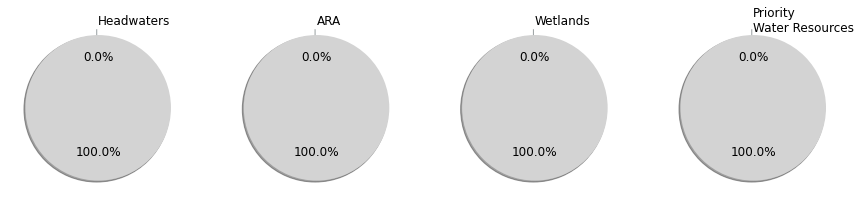

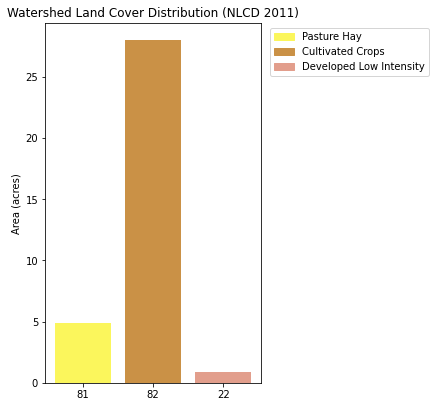

The Forest Buffer BMP treats 33.8 acres (1 percent impervious), and is estimated to reduce:
	Nitrogen: 62.54 pounds
	Phosphorus: 19.86 pounds
	Sediment: 21664.55 tons
	*Volume (cubic-ft): 56514
	*Volume (acre-ft): 1.30

*  Note: Volume reductions are applicable only to urban stormwater management.


Map(center=[40.04940659324503, -76.03691294097999], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [74]:
############################
# FINAL VISUALIZATION PAGE #
############################

# Show land cover summary
print('Total Drainage Area Acres: {}'.format(round(lu_total_bmp,2)))
# for lulc, sqm in lulcs.items():
#     print('{}: {}'.format(lulc, round(sqm,2)), end =", ")

print('Percent Impervious: {}%'.format(round(p_impervious, 2)))

# Show PWR summary, use the wetlands from the landcover call
pwr_labels = {'str_bank': 'Stream Bank (mi)', 'head_pwr': 'Headwaters (ac)', 'ara_pwr': 'Active River Area (ac)'
              , 'wet_pwr': 'Wetlands (ac)', 'tot_pwr': 'Total Priority Water Resources (PWR) (ac)'}
wetlands_acres = 0
for lulc, acre in lulcs.items():
    if lulc == '90' or lulc == '95':
        wetlands_acres += acre

try:
    wetlands_percent = wetlands_acres / lu_total * 100
except:
    print("Total Area Returned Zero")

for r, sqm in pwr.items():
    if r == 'wet_pwr':
        print('{}: {}'.format(pwr_labels[r], round(wetlands_acres,2)))
    else:
        print('{}: {}'.format(pwr_labels[r], round(sqm,2)))

###############################
# Pie charts for the PWR call #
###############################

labels_head = 'Headwaters', ''
sizes_head = [pwr_percent['head_pwr'], 100 - pwr_percent['head_pwr']]

labels_ara = 'ARA', ''
sizes_ara = [pwr_percent['ara_pwr'], 100 - pwr_percent['ara_pwr']]

labels_wet = 'Wetlands', ''
sizes_wet = [wetlands_percent, 100 - wetlands_percent]

labels_pwr = 'Priority\nWater Resources', ''
sizes_pwr = [pwr_percent['tot_pwr'], 100 - pwr_percent['tot_pwr']]

explode = (0.1, 0.0)  # only "explode" the 1st slice
pie_colors = ["lightblue", "lightgrey"]

fig1, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
fig1.set_size_inches(15,15)

ax1.pie(sizes_head, explode=explode, labels=labels_head, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = pie_colors, textprops={'fontsize': 12})

ax2.pie(sizes_ara, explode=explode, labels=labels_ara, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = pie_colors, textprops={'fontsize': 12})

ax3.pie(sizes_wet, explode=explode, labels=labels_wet, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = pie_colors, textprops={'fontsize': 12})

ax4.pie(sizes_pwr, explode=explode, labels=labels_pwr, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = pie_colors, textprops={'fontsize': 12})

plt.show()

##########################
# Create Land Cover Plot #
##########################

plot_length = int(len(lulcs))
if plot_length > 10:
    plot_length = 10

fig2 = plt.figure()
fig2.set_size_inches(plot_length,5)
ax2 = fig2.add_axes([0,0,1,1])

colormap = {'11': '#5475a8','21': '#e8d1d1','22': '#e29e8c','23': '#ff0000','24': '#b50000','31': '#d2cdc0',
            '41': '#86c77e','42': '#39814e','43': '#d5e7b0','52': '#dcca8f','71': '#fde9aa','81': '#fbf65c',
            '82': '#ca9146','90': '#c8e6f8','95': '#64b3d5'}

crosswalk = {'11': 'Open Water',
             '21': 'Developed Open Space',
             '22': 'Developed Low Intensity',
             '23': 'Developed Medium Intensity',
             '24': 'Developed High Intensity',
             '31': 'Barren Land',
             '41': 'Deciduous Forest',
             '42': 'Evergreen Forest',
             '43': 'Mixed Forest',
             '52': 'Shrub/Scrub',
             '71': 'Grassland Herbaceous',
             '81': 'Pasture Hay',
             '82': 'Cultivated Crops',
             '90': 'Woody Wetlands',
             '95': 'Emergent Herbaceous Wetlands'}

colors = {x: colormap[x] for x in lulcs}
x_labels = {x: crosswalk[x] for x in lulcs}

ax2.bar(list(lulcs.keys()), list(lulcs.values()), align='center', color=colors.values())
#ax.set_xticklabels(x_labels.values())
ax2.set_ylabel('Area (acres)')
ax2.set_title('Watershed Land Cover Distribution (NLCD 2011)')
handles = [plt.Rectangle((0,0),len(lulcs),len(lulcs), color=colors[label]) for label in x_labels]
ax2.legend(handles, x_labels.values(), bbox_to_anchor=(1.02, 1), loc='upper left')

plt.show()

##########################
# Show Reductions #
##########################

volume_cf = ((p_impervious * (lu_total_bmp * 6273000)) * runoff_capture) * 0.000578704
volume_acft = volume_cf * 0.0000229569

if reductions['tss'] <= 2000.0:
    print('The %s BMP treats %.1f acres (%.0f percent impervious), and is estimated to reduce:\n\tNitrogen: %.2f pounds\n'
    '\tPhosphorus: %.2f pounds\n'
    '\tSediment: %.2f pounds\n'
    '\t*Volume (cubic-ft): %.0f\n'
    '\t*Volume (acre-ft): %.2f\n' % (bmp, lu_total_bmp, p_impervious, reductions['tn'],reductions['tp'],reductions['tss'], volume_cf, volume_acft))
else:
    print('The %s BMP treats %.1f acres (%.0f percent impervious), and is estimated to reduce:\n\tNitrogen: %.2f pounds\n'
    '\tPhosphorus: %.2f pounds\n'
    '\tSediment: %.2f tons\n'
    '\t*Volume (cubic-ft): %.0f\n'
    '\t*Volume (acre-ft): %.2f\n' % (bmp, lu_total_bmp, p_impervious, reductions['tn'],reductions['tp'],reductions['tss'], volume_cf, volume_acft))

print('*  Note: Volume reductions are applicable only to urban stormwater management.')
if archetype == 'Urban Stormwater Management':
    if acres_treated > lu_total:
        print('** Warning: Number of sewershed acres treated given (%.2f) is larger than the expected overland drainage area (%.2f).'%(acres_treated, lu_total))
    elif 0 < acres_treated < lu_total:
        print('** Warning: Number of sewershed acres treated given (%.2f) is smaller than the expected overland drainage area (%.2f). The calculated drainage area does not consider subsurface pipe networks so this is to be expected with urban stormwater networks.'%(acres_treated, lu_total))
elif archetype == 'Polygon Drainage' or archetype == 'Exclusion Buffer':
    if 'Buffer' in bmp and lu_total > 100.0:
        print("** Warning: The buffer drains a large area (%.2f acres) and may contain concentrated flow paths, which would reduce estimated reduction."%(lu_total))

################
# Show the map #
################

displaymap2

###### Scratch Space (save outputs temporarily)
